<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/06_TC1_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [ ]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1


In [ ]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')


In [ ]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [ ]:
# outcome = encode(outcome['Project_id'])

# Random Forest

In [ ]:
np.random.seed(123)
# define the model
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# fit the model
model.fit(TC1data15, outcome['Project_id'])



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
# get importance
importance = model.feature_importances_


In [ ]:
feature = pd.DataFrame()
feature['name'] = TC1data15.columns

In [ ]:
feature['importance'] = importance
feature

,name,importance
0,TSPAN6,0.000004
1,TNMD,0.000000
2,DPM1,0.000039
3,SCYL3,0.000000
4,C1orf112,0.000002
...,...,...
60478,Metazoa_SRP.305,0.000000
60479,AJ271736.1.1,0.000000
60480,MIR6089.1,0.000000
60481,RP13-465B17.5.1,0.000000


In [ ]:
feature_sort = feature.sort_values(by='importance',ascending=False)


,name,importance
10258,SLC45A3,0.003607
36533,CTD-2182N23.1,0.003576
29180,AC012123.1,0.003306
6445,NAPSA,0.002897
12521,C8orf46,0.002802
...,...,...
37013,HNF1A-AS1,0.001027
25514,TMSB4XP4,0.001024
60030,CH507-513H4.3,0.001022
16469,BCAM,0.001012


# ConvNN(RF) - top 129

## Train/Test split    

In [ ]:
# from keras.utils import to_categorical
outcome = encode(outcome['Project_id'])

Shape of data (BEFORE encode): (4500,)
Shape of data (AFTER  encode): (4500, 15)



In [ ]:
feature_sort_selected = feature_sort[feature_sort['importance'] > 0.001]
feature_sort_selected

In [ ]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [ ]:
X_train

,SLC45A3,CTD-2182N23.1,AC012123.1,NAPSA,C8orf46,AL161626.1,RP11-264B14.2,FP236383.9,SOX17,ACSM2B,PAX8,U47924.27,PSD2,FP671120.6,TRPS1,NKX2-1-AS1,CHRNA2,TSHR,GAL3ST1,SLC28A1,APOC3,Y_RNA.262,C8B,SNRPGP10,RP11-25I15.1,SLC17A3,SLC2A2,SLC39A5,TM4SF5,PCA3,RMST,ATP8A2P1,MGAT4C,HEPH,ORM2,PLG,CRYGN,RP11-53M11.5,TRABD2A,IYD,...,TTC21B-AS1,BHMT2,NAT8,FRMD3,SLC22A31,HAO1,SFTPA1,WT1,IRX5,MUC15,RP11-114N19.3,GPA33,MYO1A,DGKA,RP11-13J10.1,HPX,RP11-710C12.1,FER1L4,FUT4,SEMA5B,RAPGEF3,HNF4A,ANKS4B,SLC5A10,CUX2,FLJ20021,HOXA11,SLC26A4-AS1,RP11-108P20.4,ARHGEF38,CREB3L4,SLC22A6,GATA3,SLC17A1,KCNN2,HNF1A-AS1,TMSB4XP4,CH507-513H4.3,BCAM,RP11-115N4.1
849,0.717435,0.000000,0.000000,3.672119,0.000000,0.000000,0.000000,0.000000,0.424186,0.000000,0.170832,1.493830,0.000000,0.000000,0.094042,1.026745,0.0,0.000000,0.924745,0.000000,0.0,0.000000,0.079015,0.615134,0.000000,0.000,0.00000,0.000000,0.229850,0.0,0.00000,0.000000,0.000000,0.752871,1.765075,0.0,0.000000,0.000000,0.184754,0.529635,...,0.000000,0.000000,0.000000,0.014796,2.716618,0.0,3.167719,0.000000,1.780820,0.812019,0.000000,0.0,0.0,0.943531,0.000000,0.000000,0.000000,0.323472,0.586924,0.000000,0.876287,0.000000,0.000000,0.000000,0.000000,1.210308,0.000000,0.00000,0.0,0.571586,1.407091,0.000000,0.417708,0.000000,0.268890,0.000000,0.752059,0.000000,2.732174,0.000000
1050,0.901859,0.000000,0.000000,0.000000,1.732119,0.000000,0.000000,0.000000,0.257574,0.000000,0.420687,0.861244,0.000000,0.000000,2.566138,0.000000,0.0,0.000000,0.000000,0.137554,0.0,0.000000,0.000000,0.473346,0.452157,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.780366,0.000000,0.993561,2.947773,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.980522,0.000000,1.472642,0.249830,0.0,0.000000,0.884083,1.840286,0.217037,0.000000,0.0,0.0,0.396074,0.000000,0.038801,0.000000,0.245857,1.068979,0.000000,0.129735,0.000000,0.000000,0.000000,0.000000,0.632624,0.000000,0.00000,0.0,0.000000,1.867953,0.000000,1.630890,0.000000,0.000000,0.000000,0.000000,0.000000,1.914717,0.000000
835,1.169069,0.000000,0.000000,0.690877,0.000000,0.365155,0.000000,0.000000,0.041478,0.000000,0.000000,1.848804,0.000000,0.157242,0.557529,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.914976,0.622720,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.659029,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.576785,0.000000,0.997362,0.640531,0.000000,0.0,0.0,1.822078,0.000000,0.228457,0.000000,0.650705,0.213690,0.063357,0.234935,0.000000,0.000000,0.000000,0.000000,1.399494,0.000000,0.00000,0.0,0.316965,1.276605,0.000000,0.000000,0.000000,0.000000,0.000000,1.159345,0.000000,2.506625,0.000000
4447,1.001501,0.000000,0.000000,0.000000,0.000000,0.393282,0.000000,0.000000,0.284720,0.000000,0.000000,1.510884,0.000000,0.000000,0.039429,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.537337,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.589360,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.386256,0.000000,0.000000,0.000000,0.0,0.0,1.020446,0.000000,0.000000,0.000000,2.076092,0.235987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.217671,0.929124,0.00000,0.0,0.000000,0.853477,0.000000,2.711598,0.000000,0.000000,0.000000,0.756108,0.000000,1.920132,0.000000
53,0.429030,0.000000,0.698742,0.094371,0.000000,2.670652,0.708519,2.400472,2.316836,0.000000,1.962383,1.967081,0.000000,1.948668,1.550796,0.000000,0.0,0.000000,0.365934,0.000000,0.0,0.092616,0.000000,1.604855,1.268017,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.480250,0.000000,0.0,0.000000,1.133977,0.475185,0.000000,...,0.000000,0.000000,0.000000,0.889395,0.294703,0.0,0.000000,2.166122,0.000000,0.716844,0.000000,0.0,0.0,0.289258,0.000000,0.000000,0.029921,0.000000,0.450754,1.161756,1.021279,0.000000,0.000000,0.000000,0.000000,1.168555,0.233019,0.00000,0.0,0.000000,1.809214,0.000000,0.866541,0.000000,0.0000

## CONV1D 

In [ ]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=100

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [ ]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [ ]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 110, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 110, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 101, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0

In [ ]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [ ]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [ ]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/100
168/169 [============================>.] - ETA: 0s - loss: 1.0708 - acc: 0.6726
Epoch 00001: val_loss improved from inf to 0.46506, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 12s 73ms/step - loss: 1.0675 - acc: 0.6738 - val_loss: 0.4651 - val_acc: 0.8516
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.3445 - acc: 0.8883
Epoch 00002: val_loss improved from 0.46506 to 0.27360, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 13s 75ms/step - loss: 0.3445 - acc: 0.8883 - val_loss: 0.2736 - val_acc: 0.9120
Epoch 3/100
168/169 [============================>.] - ETA: 0s - loss: 0.2411 - acc: 0.9250
Epoch 00003: val_loss improved from 0.27360 to 0.23414, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 12s 72ms/step - loss: 0.2403 - acc

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2809215188026428
Test accuracy: 0.9502221941947937


Text(0.5, 0, 'epoch')

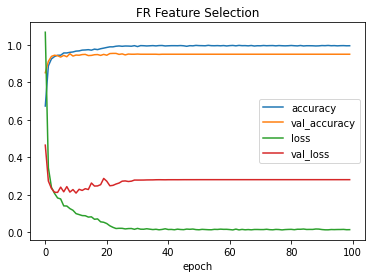

In [ ]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [ ]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [ ]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.31975093483924866
Test accuracy: 0.9528889060020447
accuracy: 95.29%


# ConvNN(RF) - top 518

## Train/Test split    

In [ ]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [ ]:
feature_sort_selected = feature_sort[feature_sort['importance'] > 0.0005]
feature_sort_selected

,name,importance
10258,SLC45A3,0.003607
36533,CTD-2182N23.1,0.003576
29180,AC012123.1,0.003306
6445,NAPSA,0.002897
12521,C8orf46,0.002802
...,...,...
16420,TMPRSS6,0.000504
30704,LINC00271,0.000504
13539,PTPRM,0.000504
5141,NCAPH,0.000504


In [ ]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [ ]:
X_train

,SLC45A3,CTD-2182N23.1,AC012123.1,NAPSA,C8orf46,AL161626.1,RP11-264B14.2,FP236383.9,SOX17,ACSM2B,PAX8,U47924.27,PSD2,FP671120.6,TRPS1,NKX2-1-AS1,CHRNA2,TSHR,GAL3ST1,SLC28A1,APOC3,Y_RNA.262,C8B,SNRPGP10,RP11-25I15.1,SLC17A3,SLC2A2,SLC39A5,TM4SF5,PCA3,RMST,ATP8A2P1,MGAT4C,HEPH,ORM2,PLG,CRYGN,RP11-53M11.5,TRABD2A,IYD,...,KRT16P2,CDC25B,LINC00958,FGF18,CHST13,CEP55,FABP1,WNK4,PAGE4,RAB6C-AS1,PAM,RP11-599B13.3,PLA2G4F,HOXA9,VGLL1,RP5-967N21.11,MARC2,ZNF541,TRIM15,CKAP2L,HOXC9,BIRC5,RGAG4,LIPH,RP11-285E23.2,BDH2,G6PC3,AR,SH3RF2,SCGB2A1,SPP2,LA16c-312E8.4,PKP3,CITED1,CTB-36O1.4,TMPRSS6,LINC00271,PTPRM,NCAPH,SLC6A3
849,0.717435,0.000000,0.000000,3.672119,0.000000,0.000000,0.000000,0.000000,0.424186,0.000000,0.170832,1.493830,0.000000,0.000000,0.094042,1.026745,0.0,0.000000,0.924745,0.000000,0.0,0.000000,0.079015,0.615134,0.000000,0.000,0.00000,0.000000,0.229850,0.0,0.00000,0.000000,0.000000,0.752871,1.765075,0.0,0.000000,0.000000,0.184754,0.529635,...,0.846334,1.931741,0.286145,0.092101,0.000000,0.670893,0.0,0.0,0.000000,0.0,2.114156,0.000000,0.763569,0.000000,0.517548,0.585738,1.700248,0.380702,0.000000,0.109185,0.511817,0.614766,0.554460,2.062177,0.000000,1.026451,1.733515,0.750422,0.128029,0.451394,1.214561,0.606132,1.721816,0.000000,0.000000,1.691488,0.000000,1.509945,0.391520,0.000000
1050,0.901859,0.000000,0.000000,0.000000,1.732119,0.000000,0.000000,0.000000,0.257574,0.000000,0.420687,0.861244,0.000000,0.000000,2.566138,0.000000,0.0,0.000000,0.000000,0.137554,0.0,0.000000,0.000000,0.473346,0.452157,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.780366,0.000000,0.993561,2.947773,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.392027,0.000000,0.000000,0.000000,1.834421,0.0,0.0,0.000000,0.0,2.052220,0.000000,0.000000,0.000000,0.762665,0.252325,0.831562,0.000000,0.000000,1.379318,0.131957,2.203330,0.128463,0.679752,0.000000,0.988780,1.633399,0.429567,0.000000,0.941200,0.000000,0.000000,2.150359,0.000000,0.000000,0.178443,0.000000,0.931182,1.476843,0.000000
835,1.169069,0.000000,0.000000,0.690877,0.000000,0.365155,0.000000,0.000000,0.041478,0.000000,0.000000,1.848804,0.000000,0.157242,0.557529,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.914976,0.622720,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.659029,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.040108,2.043236,1.027411,0.348096,0.000000,1.508080,0.0,0.0,0.000000,0.0,1.782595,0.000000,1.241283,0.925288,0.079355,1.113506,0.939554,0.000000,0.000000,0.855996,1.116087,1.854245,0.743807,0.778923,0.000000,1.502086,1.585139,0.031703,1.356941,0.103162,0.000000,0.000000,2.111933,0.000000,0.046214,0.000000,0.000000,0.597420,1.288918,0.000000
4447,1.001501,0.000000,0.000000,0.000000,0.000000,0.393282,0.000000,0.000000,0.284720,0.000000,0.000000,1.510884,0.000000,0.000000,0.039429,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.537337,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.589360,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.351233,0.772481,0.000000,0.000000,1.318423,0.0,0.0,0.000000,0.0,1.296706,0.000000,0.612812,1.256689,2.039085,1.128795,0.980197,0.000000,0.000000,0.980573,0.572466,1.411829,0.032112,0.304901,0.000000,1.173131,1.500076,0.000000,0.000000,0.000000,0.000000,0.000000,1.868184,0.000000,0.000000,0.000000,0.000000,1.288972,1.135975,0.000000
53,0.429030,0.000000,0.698742,0.094371,0.000000,2.670652,0.708519,2.400472,2.316836,0.000000,1.962383,1.967081,0.000000,1.948668,1.550796,0.000000,0.0,0.000000,0.365934,0.000000,0.0,0.092616,0.000000,1.604855,1.268017,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.480250,0.000000,0.0,0.000000,1.133977,0.475185,0.000000,...,0.000000,1.915313,1.262870,0.537637,0.303451,1.644392,0.0,0.0,0.000000,0.0,1.338379,0.107885,0.000000,0.815124,1.768175,0.958802,0.681281,0.215052,0.155523,1.239451,0.837586,1.902639,0.762819,0.722267,0.000000,0.923130,1.998748,1.426661,1.212653,2.653249,0.000000,0.000000,1.842547,0.00000

## CONV1D 

In [ ]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=100

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [ ]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [ ]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 499, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 499, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 499, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 490, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 490, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [ ]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [ ]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 1.2712 - acc: 0.5748
Epoch 00001: val_loss improved from inf to 0.40486, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 44s 263ms/step - loss: 1.2712 - acc: 0.5748 - val_loss: 0.4049 - val_acc: 0.8640
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.2904 - acc: 0.9061
Epoch 00002: val_loss improved from 0.40486 to 0.25729, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.2904 - acc: 0.9061 - val_loss: 0.2573 - val_acc: 0.9244
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.1880 - acc: 0.9437
Epoch 00003: val_loss improved from 0.25729 to 0.16209, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 44s 262ms/step - loss: 0.1880 - 

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.230394184589386
Test accuracy: 0.9653333425521851


Text(0.5, 0, 'epoch')

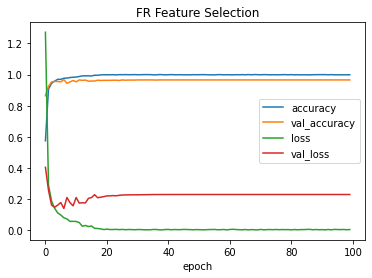

In [ ]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [ ]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [ ]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.230394184589386
Test accuracy: 0.9653333425521851
accuracy: 96.53%


# ConvNN(RF) - top 300

## Train/Test split    

In [ ]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [ ]:
feature_sort_selected = feature_sort.iloc[:300,:]
feature_sort_selected

,name,importance
10258,SLC45A3,0.003607
36533,CTD-2182N23.1,0.003576
29180,AC012123.1,0.003306
6445,NAPSA,0.002897
12521,C8orf46,0.002802
...,...,...
3724,B3GAT1,0.000643
29500,ORM1,0.000643
46193,RP11-320M16.1,0.000643
37443,CTD-2377D24.4,0.000640


In [ ]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [ ]:
X_train

,SLC45A3,CTD-2182N23.1,AC012123.1,NAPSA,C8orf46,AL161626.1,RP11-264B14.2,FP236383.9,SOX17,ACSM2B,PAX8,U47924.27,PSD2,FP671120.6,TRPS1,NKX2-1-AS1,CHRNA2,TSHR,GAL3ST1,SLC28A1,APOC3,Y_RNA.262,C8B,SNRPGP10,RP11-25I15.1,SLC17A3,SLC2A2,SLC39A5,TM4SF5,PCA3,RMST,ATP8A2P1,MGAT4C,HEPH,ORM2,PLG,CRYGN,RP11-53M11.5,TRABD2A,IYD,...,GPR157,SCTR,PPAP2B,LCN12,MEIS1,TMEM243,LLNLF-187D8.1,F9,NCAN,AC021218.2,DOCK3,CAPN13,TPO,LINC00320,PHKG1,LRRN1,DNER,GRIA3,S100A2,NPY,FP671120.5,FAM83H,APOB,RP11-2E11.5,MASP2,PGC,AC012354.8,CPB2,GRHL2,NAAA,KLHL35,KRT6A,KCNJ10,SERPINB13,RP11-429B14.4,B3GAT1,ORM1,RP11-320M16.1,CTD-2377D24.4,CDH6
849,0.717435,0.000000,0.000000,3.672119,0.000000,0.000000,0.000000,0.000000,0.424186,0.000000,0.170832,1.493830,0.000000,0.000000,0.094042,1.026745,0.0,0.000000,0.924745,0.000000,0.0,0.000000,0.079015,0.615134,0.000000,0.000,0.00000,0.000000,0.229850,0.0,0.00000,0.000000,0.000000,0.752871,1.765075,0.0,0.000000,0.000000,0.184754,0.529635,...,1.065158,0.733559,1.580060,0.556286,0.571990,1.290002,0.000000,0.0,0.0,0.000000,0.000000,1.357876,0.000000,0.0,0.028038,0.700337,0.343320,0.0,1.018920,0.000000,0.00000,2.045059,0.0,0.0,0.000000,3.095648,0.000000,0.794982,1.636991,1.061681,0.603725,1.469228,0.0,0.000000,0.0,0.000000,2.223209,0.000000,0.000000,0.272571
1050,0.901859,0.000000,0.000000,0.000000,1.732119,0.000000,0.000000,0.000000,0.257574,0.000000,0.420687,0.861244,0.000000,0.000000,2.566138,0.000000,0.0,0.000000,0.000000,0.137554,0.0,0.000000,0.000000,0.473346,0.452157,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.780366,0.000000,0.993561,2.947773,0.0,0.000000,0.000000,0.000000,0.000000,...,1.252547,0.000000,1.716243,0.000000,0.473386,1.023498,0.000000,0.0,0.0,0.000000,0.000000,0.064520,0.000000,0.0,0.000000,1.121711,0.000000,0.0,0.624630,0.000000,0.00000,2.433008,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.734314,1.367369,0.239177,0.000000,0.0,0.000000,0.0,0.000000,3.375890,0.000000,0.000000,0.000000
835,1.169069,0.000000,0.000000,0.690877,0.000000,0.365155,0.000000,0.000000,0.041478,0.000000,0.000000,1.848804,0.000000,0.157242,0.557529,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.914976,0.622720,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.659029,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.988589,0.000000,1.319069,0.744653,0.793214,1.069496,0.000000,0.0,0.0,0.000000,0.594582,0.000000,0.000000,0.0,0.134651,0.553795,0.000000,0.0,3.626405,1.165371,0.00000,2.104592,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.713397,0.566962,0.000000,3.511951,0.0,0.746622,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4447,1.001501,0.000000,0.000000,0.000000,0.000000,0.393282,0.000000,0.000000,0.284720,0.000000,0.000000,1.510884,0.000000,0.000000,0.039429,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.537337,0.000000,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.589360,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,1.339144,0.000000,1.411680,0.079273,0.714604,1.132097,0.000000,0.0,0.0,0.056761,0.780352,0.730571,0.000000,0.0,0.000000,1.035213,0.000000,0.0,2.613861,0.000000,0.00000,1.809261,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.153790,0.885525,0.000000,0.000000,0.0,0.000000,0.0,0.281632,0.000000,0.000000,0.000000,0.151640
53,0.429030,0.000000,0.698742,0.094371,0.000000,2.670652,0.708519,2.400472,2.316836,0.000000,1.962383,1.967081,0.000000,1.948668,1.550796,0.000000,0.0,0.000000,0.365934,0.000000,0.0,0.092616,0.000000,1.604855,1.268017,0.000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.480250,0.000000,0.0,0.000000,1.133977,0.475185,0.000000,...,1.337691,0.000000,1.640065,1.325293,1.494002,1.258171,0.000000,0.0,0.0,0.000000,0.766147,0.963744,0.000000,0.0,0.091356,1.227083,0.000000,0.0,1.804598,0.000000,1.37167,2.186938,0.0,0.0,0.000000,0.000000,0.721946,0.000000,1.543859,0.980574,0.875821,0.100771,0.0,0.000000,0.0,0.000000,0.035793,0.581620,0.000000,1.625373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## CONV1D 

In [ ]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=100

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [ ]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [ ]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [ ]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [ ]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [ ]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 1.0476 - acc: 0.6643
Epoch 00001: val_loss improved from inf to 0.29168, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 27s 158ms/step - loss: 1.0476 - acc: 0.6643 - val_loss: 0.2917 - val_acc: 0.9129
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.2865 - acc: 0.9102
Epoch 00002: val_loss improved from 0.29168 to 0.24426, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
169/169 [==============================] - 27s 158ms/step - loss: 0.2865 - acc: 0.9102 - val_loss: 0.2443 - val_acc: 0.9280
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.1995 - acc: 0.9425
Epoch 00003: val_loss did not improve from 0.24426
169/169 [==============================] - 27s 158ms/step - loss: 0.1995 - acc: 0.9425 - val_loss: 0.2903 - val_acc: 0.9067
Epoch 4/100
169/169 [==============

In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.22035759687423706
Test accuracy: 0.9599999785423279


Text(0.5, 0, 'epoch')

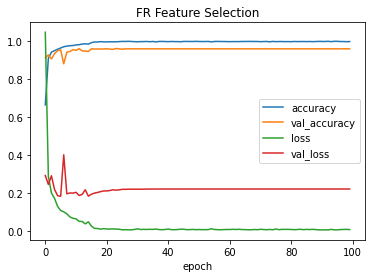

In [ ]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [ ]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [ ]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.22035759687423706
Test accuracy: 0.9599999785423279
accuracy: 96.00%
